In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score

# Loading Dataset

In [2]:
"""load training labels"""
label = pd.read_csv("/Users/juliachen/Desktop/DSCI552/hw/hw4/dataset/ps4_trainvalid_labels.csv")

"""load traning images"""
image = np.load("/Users/juliachen/Desktop/DSCI552/hw/hw4/dataset/ps4_trainvalid_images.npy")

"""load test for kaggle"""
test = np.load("/Users/juliachen/Desktop/DSCI552/hw/hw4/dataset/ps4_kaggle_images.npy")

In [3]:
#np.set_printoptions(threshold=sys.maxsize)
#print(label)

#### 1. Data Preprocessing- cast image 

In [4]:
""" preprocessing, cast from uint8 to float"""
image = image.astype(np.float)
print("Data type: ", image.dtype)

Data type:  float64


In [5]:
"""look at label dataset"""
print(label)

          Id  Label
0          0      0
1          1      0
2          2      0
3          3      0
4          4      0
...      ...    ...
13255  13255      1
13256  13256      1
13257  13257      0
13258  13258      2
13259  13259      0

[13260 rows x 2 columns]


#### 2. Data Preprocessing- remove first Id col and cast to float

In [6]:
"""remove Id column since it is duplicated"""
label = label["Label"]
label = np.array(label).astype("float")

In [7]:
print("Number of dimensions for image dataset: ", image.ndim)
print("Lengh of dimensions for image dataset: ", image.shape)
print("Total number of elements for image dataset: ", image.size)
print("Data type for image dataset: ", image.dtype)

Number of dimensions for image dataset:  4
Lengh of dimensions for image dataset:  (13260, 64, 64, 1)
Total number of elements for image dataset:  54312960
Data type for image dataset:  float64


In [8]:
print("Number of dimensions for image dataset: ", label.ndim)
print("Lengh of dimensions for image dataset: ", label.shape)
print("Total number of elements for image dataset: ", label.size)
print("Data type for image dataset: ", label.dtype)

Number of dimensions for image dataset:  1
Lengh of dimensions for image dataset:  (13260,)
Total number of elements for image dataset:  13260
Data type for image dataset:  float64


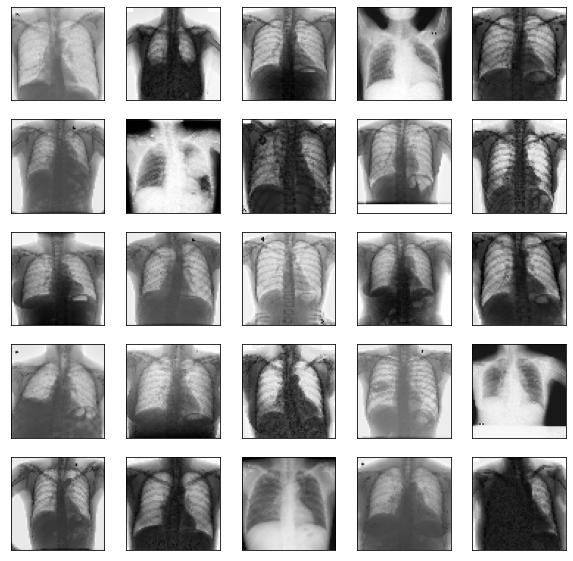

In [9]:
"""explore the images"""
#class_names = ['Pre-exsiting','Healthy','Effusion']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i],cmap=plt.cm.binary)
    #plt.xlabel(class_names[label[i][0]])
plt.show()

# Split into training and validation set and prepare test data

In [10]:
"""Create random indices"""
np.random.seed(44)
N = len(label)
shuffled_indices = np.random.permutation(N)

"""Split indices into train and val set"""
train_indices = shuffled_indices[:int(N*0.8)]
valid_indices = shuffled_indices[int(N*0.8):]

"""Split and Normalizating """ 
train_x = image[train_indices]/255
valid_x = image[valid_indices]/255
train_y = label[train_indices]
valid_y = label[valid_indices]

In [11]:
'''Split and Normalizating on test set'''
test = test/255

In [12]:
print(train_x.shape)
print(valid_x.shape)
print(train_y.shape)
print(valid_y.shape)
print(test.shape)

(10608, 64, 64, 1)
(2652, 64, 64, 1)
(10608,)
(2652,)
(300, 64, 64, 1)


# Create weight to deal with imbalance

In [13]:
unique, counts = np.unique(label, return_counts=True)
dict(zip(unique, counts))
counts

array([10506,  2372,   382])

In [14]:
#weight=counts/ counts.sum()
weights = {0: 1/counts[0]*counts.sum()/2,  1: 1/counts[1]*counts.sum()/2, 2: 1/counts[2]*counts.sum()/2}
weights

{0: 0.6310679611650486, 1: 2.7951096121416525, 2: 17.356020942408378}

# CNN LeNet-5 From Lecture note

In [15]:
np.random.seed(44)
lenet5 = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu', input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

lenet5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

lenet5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 20)        10020     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3380)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1690500   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [16]:
history1=lenet5.fit(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
332/332 [==============================] - 42s 124ms/step - loss: 0.6616 - accuracy: 0.7580 - val_loss: 0.4746 - val_accuracy: 0.8190
Epoch 2/5
332/332 [==============================] - 33s 100ms/step - loss: 0.4251 - accuracy: 0.8335 - val_loss: 0.3908 - val_accuracy: 0.8658
Epoch 3/5
332/332 [==============================] - 36s 108ms/step - loss: 0.3591 - accuracy: 0.8720 - val_loss: 0.3465 - val_accuracy: 0.8831
Epoch 4/5
332/332 [==============================] - 36s 108ms/step - loss: 0.3208 - accuracy: 0.8827 - val_loss: 0.3065 - val_accuracy: 0.8918
Epoch 5/5
332/332 [==============================] - 34s 104ms/step - loss: 0.2824 - accuracy: 0.9005 - val_loss: 0.3018 - val_accuracy: 0.8865


83/83 - 1s - loss: 0.3018 - accuracy: 0.8865


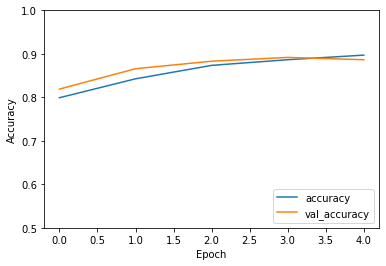

In [17]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = lenet5.evaluate(valid_x,  valid_y, verbose=2)

In [18]:
# prediction on validation set 
valid_pred1 = lenet5.predict_generator(valid_x)
valid_pred1 = np.argmax(valid_pred1, axis=1)

/Users/juliachen/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [19]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred1))
print("Micro F1 score: ",f1_score(valid_y, valid_pred1, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred1, average='macro'))

Confusion Matrix:
 [[1982  120    0]
 [ 103  369    0]
 [  23   55    0]]
Micro F1 score:  0.8865007541478128
Macro F1 score:  0.555981882905967


In [20]:
precision, recall, fscore, support = score(valid_y, valid_pred1, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.94291151 0.78177966 0.        ]


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Saving testing data
pred_test1 = lenet5.predict_generator(test)
pred_test1 = np.argmax(pred_test1, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test1})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions1.csv', index=False)
print("Kaggle Result:", 0.56296)

Kaggle Result: 0.56296


# --------------------weighted-------------------------------------------

In [22]:
history1_weighted=lenet5.fit(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y),
                             class_weight=weights)

Epoch 1/5
332/332 [==============================] - 41s 122ms/step - loss: 1.3635 - accuracy: 0.6783 - val_loss: 0.5918 - val_accuracy: 0.7681
Epoch 2/5
332/332 [==============================] - 27s 81ms/step - loss: 1.0985 - accuracy: 0.7614 - val_loss: 0.5949 - val_accuracy: 0.7658
Epoch 3/5
332/332 [==============================] - 26s 79ms/step - loss: 1.0100 - accuracy: 0.7979 - val_loss: 0.5315 - val_accuracy: 0.7870
Epoch 4/5
332/332 [==============================] - 26s 79ms/step - loss: 0.9139 - accuracy: 0.8165 - val_loss: 0.4429 - val_accuracy: 0.8126
Epoch 5/5
332/332 [==============================] - 35s 106ms/step - loss: 0.8330 - accuracy: 0.8351 - val_loss: 0.4184 - val_accuracy: 0.8326


83/83 - 2s - loss: 0.4184 - accuracy: 0.8326


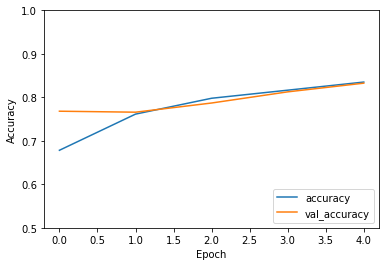

In [23]:
plt.plot(history1_weighted.history['accuracy'], label='accuracy')
plt.plot(history1_weighted.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = lenet5.evaluate(valid_x,  valid_y, verbose=2)

In [24]:
# prediction on validation set 
valid_pred1 = lenet5.predict_generator(valid_x)
valid_pred1 = np.argmax(valid_pred1, axis=1)

In [25]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred1))
print("Micro F1 score: ",f1_score(valid_y, valid_pred1, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred1, average='macro'))

Confusion Matrix:
 [[1868  132  102]
 [  49  301  122]
 [   9   30   39]]
Micro F1 score:  0.8325791855203619
Macro F1 score:  0.6000322393923919


In [26]:
precision, recall, fscore, support = score(valid_y, valid_pred1, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.88867745 0.63771186 0.5       ]


In [27]:
# Saving testing data
pred_test1 = lenet5.predict_generator(test)
pred_test1 = np.argmax(pred_test1, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test1})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions1weight.csv', index=False)
print("Kaggle Result:", 0.65185)

Kaggle Result: 0.65185


# CNN - change the filter size and learning rate

In [28]:
from tensorflow.keras import regularizers
np.random.seed(44)
model = tf.keras.models.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(0.0002), input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), kernel_regularizer=regularizers.l2(0.0002), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, kernel_regularizer=regularizers.l2(0.0002), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax') 
])



opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               2704500   
_________________________________________________________________
dropout (Dropout)            (None, 500)              

In [29]:
history2=model.fit(train_x, train_y, epochs=5, validation_data=(valid_x, valid_y))

Epoch 1/5
332/332 [==============================] - 45s 132ms/step - loss: 0.7151 - accuracy: 0.7803 - val_loss: 0.4902 - val_accuracy: 0.8458
Epoch 2/5
332/332 [==============================] - 45s 134ms/step - loss: 0.4783 - accuracy: 0.8382 - val_loss: 0.4021 - val_accuracy: 0.8733
Epoch 3/5
332/332 [==============================] - 36s 107ms/step - loss: 0.4158 - accuracy: 0.8619 - val_loss: 0.3758 - val_accuracy: 0.8888
Epoch 4/5
332/332 [==============================] - 42s 127ms/step - loss: 0.3669 - accuracy: 0.8868 - val_loss: 0.3541 - val_accuracy: 0.8929
Epoch 5/5
332/332 [==============================] - 54s 161ms/step - loss: 0.3575 - accuracy: 0.8923 - val_loss: 0.3495 - val_accuracy: 0.8861


83/83 - 3s - loss: 0.3495 - accuracy: 0.8861


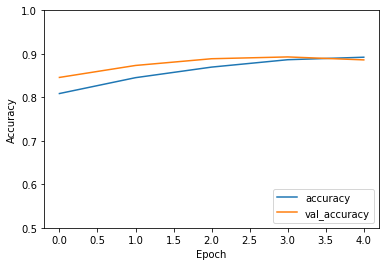

In [30]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(valid_x,  valid_y, verbose=2)

In [31]:
# prediction on validation set 
valid_pred2 = model.predict_generator(valid_x)
valid_pred2 = np.argmax(valid_pred2, axis=1)

In [32]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred2))
print("Micro F1 score: ",f1_score(valid_y, valid_pred2, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred2, average='macro'))

Confusion Matrix:
 [[2059   43    0]
 [ 181  291    0]
 [  41   37    0]]
Micro F1 score:  0.8861236802413273
Macro F1 score:  0.5433101958418552


In [33]:
precision, recall, fscore, support = score(valid_y, valid_pred2, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.97954329 0.61652542 0.        ]


In [34]:
# Saving testing data
pred_test2 = model.predict_generator(test)
pred_test2 = np.argmax(pred_test2, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test2})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions2.csv', index=False)
print("Kaggle Result:", 0.58518)

Kaggle Result: 0.58518


# ----------------------weighted--------------------------------------

In [35]:
history2_weighted=model.fit(train_x, train_y, epochs=5, validation_data=(valid_x, valid_y),
                   class_weight=weights)

Epoch 1/5
332/332 [==============================] - 37s 111ms/step - loss: 1.3410 - accuracy: 0.7429 - val_loss: 0.7862 - val_accuracy: 0.7474
Epoch 2/5
332/332 [==============================] - 37s 111ms/step - loss: 1.2298 - accuracy: 0.7819 - val_loss: 0.5837 - val_accuracy: 0.8216
Epoch 3/5
332/332 [==============================] - 48s 145ms/step - loss: 1.1469 - accuracy: 0.8051 - val_loss: 0.5601 - val_accuracy: 0.8205
Epoch 4/5
332/332 [==============================] - 45s 137ms/step - loss: 1.1179 - accuracy: 0.8072 - val_loss: 0.6228 - val_accuracy: 0.7813
Epoch 5/5
332/332 [==============================] - 37s 110ms/step - loss: 1.0928 - accuracy: 0.8136 - val_loss: 0.5970 - val_accuracy: 0.7919


In [36]:
# prediction on validation set 
valid_pred2 = model.predict_generator(valid_x)
valid_pred2 = np.argmax(valid_pred2, axis=1)

In [37]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred2))
print("Micro F1 score: ",f1_score(valid_y, valid_pred2, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred2, average='macro'))

Confusion Matrix:
 [[1802  137  163]
 [  38  247  187]
 [  10   17   51]]
Micro F1 score:  0.7918552036199095
Macro F1 score:  0.5635839287706591


In [38]:
precision, recall, fscore, support = score(valid_y, valid_pred2, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.85727878 0.52330508 0.65384615]


In [65]:
# Saving testing data
pred_test2 = model.predict_generator(test)
pred_test2 = np.argmax(pred_test2, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test2})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions2weights.csv', index=False)
print("Kaggle Result:", 0.65925)

Kaggle Result: 0.65925


# Data Augmentation on previous model

In [40]:
batch_size = 32
epochs = 20
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
np.random.seed(44)
# Data Augmentation 
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=1,
                                    zoom_range=0.10,
                                    rescale = 1/255)
                              
val_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=1,
                                    zoom_range=0.10,
                                    rescale = 1/255)
                                   
# Train 
#train_generator = data_generator.flow_from_directory('/Users/juliachen/Desktop/DSCI552/hw/hw4/dataset', target_size=(64, 64),
                                    # batch_size=batch_size, class_mode='binary', subset='training')
val_generator.fit(valid_x)
data_generator.fit(train_x)  

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


#history3 = model.fit(data_generator.flow(train_x, train_y, batch_size=32),
#                                     batch_size=32, epochs=10, 
#                      validation_data=val_generator.flow(valid_x, valid_y, batch_size=32)),
                      #callbacks=[learning_rate_reduction])


# Validation 
#validation_generator = ImageDataGenerator(valid_x, target_size=(64, 64), batch_size=batch_size, class_mode='binary',
                                          # shuffle=False, subset='validation')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               2704500   
_________________________________________________________________
dropout (Dropout)            (None, 500)              

In [42]:
#history3=model.fit(train_x, train_y, epochs=5, validation_data=(valid_x, valid_y))
history3 = model.fit(data_generator.flow(train_x, train_y, batch_size=32),
                                     batch_size=32, epochs=5, 
                      validation_data=val_generator.flow(valid_x, valid_y, batch_size=32))

Epoch 1/5
332/332 [==============================] - 41s 123ms/step - loss: 0.7398 - accuracy: 0.7883 - val_loss: 0.6818 - val_accuracy: 0.7926
Epoch 2/5
332/332 [==============================] - 40s 119ms/step - loss: 0.6797 - accuracy: 0.7922 - val_loss: 0.6527 - val_accuracy: 0.7926
Epoch 3/5
332/332 [==============================] - 37s 110ms/step - loss: 0.6461 - accuracy: 0.7921 - val_loss: 0.6086 - val_accuracy: 0.7926
Epoch 4/5
332/332 [==============================] - 39s 117ms/step - loss: 0.6095 - accuracy: 0.7925 - val_loss: 0.5846 - val_accuracy: 0.7934
Epoch 5/5
332/332 [==============================] - 39s 117ms/step - loss: 0.5839 - accuracy: 0.7926 - val_loss: 0.5685 - val_accuracy: 0.7930


83/83 - 2s - loss: 0.7346 - accuracy: 0.7342


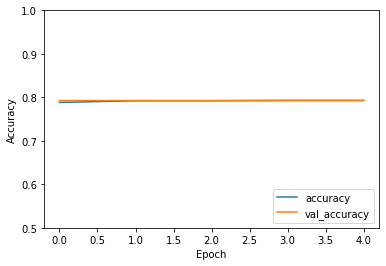

In [43]:
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(valid_x,  valid_y, verbose=2)

In [44]:
# prediction on validation set 
valid_pred3 = model.predict_generator(valid_x)
valid_pred3 = np.argmax(valid_pred3, axis=1)

In [45]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred3))
print("Micro F1 score: ",f1_score(valid_y, valid_pred3, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred3, average='macro'))

Confusion Matrix:
 [[1575  448   79]
 [  62  356   54]
 [  15   47   16]]
Micro F1 score:  0.7341628959276018
Macro F1 score:  0.5060816471985584


In [46]:
precision, recall, fscore, support = score(valid_y, valid_pred3, labels=[0,1,2], average = None)
print("Recall Rate: ", recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.74928639 0.75423729 0.20512821]


In [66]:
# Saving testing data
pred_test3 = model.predict_generator(test)
pred_test3 = np.argmax(pred_test3, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test3})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions3.csv', index=False)
print("Kaggle Result:", 0.61481)

Kaggle Result: 0.61481


# ---------------------weighted---------------------------------

In [48]:
#history3_weighted=model.fit(train_x, train_y, epochs=5, validation_data=(valid_x, valid_y),
#                     class_weight=weights)

history3 = model.fit(data_generator.flow(train_x, train_y, batch_size=32),
                                     batch_size=32, epochs=5, 
                      validation_data=val_generator.flow(valid_x, valid_y, batch_size=32),class_weight=weights)

Epoch 1/5
332/332 [==============================] - 45s 133ms/step - loss: 1.7119 - accuracy: 0.3851 - val_loss: 1.2428 - val_accuracy: 0.0294
Epoch 2/5
332/332 [==============================] - 31s 95ms/step - loss: 1.6893 - accuracy: 0.3633 - val_loss: 1.1219 - val_accuracy: 0.7926
Epoch 3/5
332/332 [==============================] - 31s 94ms/step - loss: 1.6757 - accuracy: 0.3412 - val_loss: 1.1217 - val_accuracy: 0.1780
Epoch 4/5
332/332 [==============================] - 44s 132ms/step - loss: 1.6702 - accuracy: 0.3732 - val_loss: 1.1033 - val_accuracy: 0.7926
Epoch 5/5
332/332 [==============================] - 52s 155ms/step - loss: 1.6752 - accuracy: 0.3505 - val_loss: 1.1146 - val_accuracy: 0.0294


In [49]:
# prediction on validation set 
valid_pred3 = model.predict_generator(valid_x)
valid_pred3 = np.argmax(valid_pred3, axis=1)

In [50]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred3))
print("Micro F1 score: ",f1_score(valid_y, valid_pred3, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred3, average='macro'))

Confusion Matrix:
 [[1550    7  545]
 [  96   12  364]
 [  20    0   58]]
Micro F1 score:  0.6108597285067874
Macro F1 score:  0.3275340812789615


In [51]:
precision, recall, fscore, support = score(valid_y, valid_pred3, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.73739296 0.02542373 0.74358974]


In [67]:
# Saving testing data
pred_test3 = model.predict_generator(test)
pred_test3 = np.argmax(pred_test3, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test3})
df.to_csv('/Users/juliachen/Desktop/my_predictions3weight.csv', index=False)
print("Kaggle Result:", 0.67407)

Kaggle Result: 0.67407


# VGG

In [53]:
np.random.seed(44)
vgg = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                           input_shape=(64,64,1),padding="valid", strides = 1), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"),
    
    # 2nd convolution: two convolutional layers
    tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding="valid"),
    tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"),
    
    # 3rd convolution: : two convolutional layers
    tf.keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding="valid"),
    tf.keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding="valid"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"),
    
    # dense
    tf.keras.layers.Flatten(input_shape=(64,64,1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

vgg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 128)        

In [54]:
history4=vgg.fit(train_x, train_y, epochs=5, 
           validation_data=(valid_x, valid_y))

Epoch 1/5
332/332 [==============================] - 82s 243ms/step - loss: 0.6746 - accuracy: 0.7455 - val_loss: 0.4675 - val_accuracy: 0.8145
Epoch 2/5
332/332 [==============================] - 73s 219ms/step - loss: 0.4346 - accuracy: 0.8345 - val_loss: 0.4346 - val_accuracy: 0.8752
Epoch 3/5
332/332 [==============================] - 73s 219ms/step - loss: 0.3385 - accuracy: 0.8799 - val_loss: 0.3077 - val_accuracy: 0.8906
Epoch 4/5
332/332 [==============================] - 71s 215ms/step - loss: 0.3022 - accuracy: 0.8957 - val_loss: 0.2856 - val_accuracy: 0.9054
Epoch 5/5
332/332 [==============================] - 77s 231ms/step - loss: 0.2706 - accuracy: 0.9076 - val_loss: 0.2797 - val_accuracy: 0.9076


83/83 - 4s - loss: 0.2797 - accuracy: 0.9076


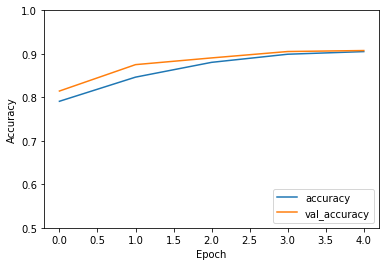

In [55]:
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = vgg.evaluate(valid_x,  valid_y, verbose=2)

In [56]:
# prediction on validation set 
valid_pred4 = vgg.predict_generator(valid_x)
valid_pred4 = np.argmax(valid_pred4, axis=1)

In [57]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred4))
print("Micro F1 score: ",f1_score(valid_y, valid_pred4, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred4, average='macro'))

Confusion Matrix:
 [[2047   55    0]
 [ 112  360    0]
 [  18   60    0]]
Micro F1 score:  0.9076168929110106
Macro F1 score:  0.5723537566592214


In [58]:
precision, recall, fscore, support = score(valid_y, valid_pred4, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.97383444 0.76271186 0.        ]


In [59]:
pred_test4 = vgg.predict_generator(test)
pred_test4 = np.argmax(pred_test4, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test4})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions4.csv', index=False)
print("Kaggle Result:", 0.54814)

Kaggle Result: 0.54814


# -----------------------weighted-----------------------------------

In [60]:
history4_weighted=vgg.fit(train_x, train_y, epochs=5, 
           validation_data=(valid_x, valid_y),class_weight=weights)

Epoch 1/5
332/332 [==============================] - 79s 235ms/step - loss: 1.2500 - accuracy: 0.7490 - val_loss: 0.6672 - val_accuracy: 0.8054
Epoch 2/5
332/332 [==============================] - 72s 214ms/step - loss: 1.1280 - accuracy: 0.7953 - val_loss: 0.6100 - val_accuracy: 0.7677
Epoch 3/5
332/332 [==============================] - 75s 227ms/step - loss: 1.0839 - accuracy: 0.8051 - val_loss: 0.4726 - val_accuracy: 0.8571
Epoch 4/5
332/332 [==============================] - 76s 228ms/step - loss: 1.0414 - accuracy: 0.8092 - val_loss: 0.4742 - val_accuracy: 0.8126
Epoch 5/5
332/332 [==============================] - 67s 202ms/step - loss: 0.9796 - accuracy: 0.8113 - val_loss: 0.5473 - val_accuracy: 0.7881


In [61]:
# prediction on validation set 
valid_pred4 = vgg.predict_generator(valid_x)
valid_pred4 = np.argmax(valid_pred4, axis=1)

In [62]:
print("Confusion Matrix:\n", confusion_matrix(valid_y, valid_pred4))
print("Micro F1 score: ",f1_score(valid_y, valid_pred4, average='micro'))
print("Macro F1 score: ",f1_score(valid_y, valid_pred4, average='macro'))

Confusion Matrix:
 [[1785   75  242]
 [  39  259  174]
 [   9   23   46]]
Micro F1 score:  0.7880844645550528
Macro F1 score:  0.5674874266889979


In [63]:
precision, recall, fscore, support = score(valid_y, valid_pred4, labels=[0,1,2], average = None)
print("Recall Rate: ",recall)
# first one is 0, second is 1, third is 2 

Recall Rate:  [0.84919125 0.54872881 0.58974359]


In [68]:
pred_test4 = vgg.predict_generator(test)
pred_test4 = np.argmax(pred_test4, axis=1)
df = pd.DataFrame.from_dict({'Id': range(0,300), 'Predicted': pred_test4})
#df.to_csv('/Users/juliachen/Desktop/DSCI552/hw/hw4/testdata/my_predictions4_weight.csv', index=False)
print("Kaggle Result:", 0.65925)

Kaggle Result: 0.65925
